In [6]:
import sys
sys.path.append('../src')
import os
from project_utilities.config import DATA_DIR_RAW

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# XGBoost 
import xgboost as xgb
from xgboost import XGBClassifier

# SKLEARN
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.metrics import recall_score, accuracy_score, mean_squared_error
# Model Optimizer
from bayes_opt import BayesianOptimization

# Progress Bar
from tqdm import tqdm, tqdm_notebook

In [7]:
os.chdir(DATA_DIR_RAW)

In [12]:
train_data = np.load('raw/npy/train_data.npy')
val_data = np.load('raw/npy/val_data.npy')

y_train = train_data[:,-1]
y_train.reshape(y_train.size,1)
print(f'Shape for y_train: {y_train.shape}')

X_train = train_data[:,:-1]
print(f'Shape for X_train: {X_train.shape}')


y_val = val_data[:,-1]
y_val.reshape(y_val.size,1)
print(f'Shape for y_val: {y_val.shape}')

X_val = val_data[:,:-1]
print(f'Shape for X_val: {X_val.shape}')

Shape for y_train: (11543,)
Shape for X_train: (11543, 50176)
Shape for y_val: (983,)
Shape for X_val: (983, 50176)


In [9]:
ipca = IncrementalPCA(n_components=1000)

X_train_reduced = None
first = True
for batch in tqdm_notebook(np.array_split(X_train, X_train.shape[0]/1000)):
    ipca.partial_fit(batch)
    transformed_batch = ipca.transform(batch)
    # First batch is directly assigned to reduced.
    if first == True:
        X_train_reduced = transformed_batch
        first = False
    else:
        X_train_reduced = np.vstack((X_train_reduced, transformed_batch))

In [10]:
        
# Shape of the reduced dataset
print(f'The reduced shape is: {X_train_reduced.shape}')

# Percent of varience explained by the subset of features
print(f'The total explained varience is: {ipca.explained_variance_ratio_.sum()}')

The reduced shape is: (11543, 1000)
The total explained varience is: 0.9446159755175982


In [13]:
X_val_reduced = ipca.transform(X_val)
X_val_reduced.shape

(983, 1000)

In [14]:
xgb_model_1 = XGBClassifier()
xgb_model_1.fit(X_train_reduced, y_train, eval_metric=['error'], eval_set=[(X_train_reduced, y_train),(X_val_reduced, y_val)])

[0]	validation_0-error:0.20662	validation_1-error:0.17904
[1]	validation_0-error:0.18531	validation_1-error:0.15463
[2]	validation_0-error:0.17240	validation_1-error:0.15158
[3]	validation_0-error:0.16053	validation_1-error:0.13327
[4]	validation_0-error:0.15291	validation_1-error:0.13123
[5]	validation_0-error:0.14190	validation_1-error:0.12716
[6]	validation_0-error:0.13107	validation_1-error:0.12411
[7]	validation_0-error:0.12077	validation_1-error:0.12716
[8]	validation_0-error:0.11384	validation_1-error:0.12106
[9]	validation_0-error:0.10179	validation_1-error:0.10682
[10]	validation_0-error:0.09504	validation_1-error:0.10682
[11]	validation_0-error:0.08707	validation_1-error:0.10376
[12]	validation_0-error:0.08247	validation_1-error:0.10580
[13]	validation_0-error:0.07303	validation_1-error:0.10071
[14]	validation_0-error:0.06619	validation_1-error:0.09868
[15]	validation_0-error:0.05978	validation_1-error:0.09156
[16]	validation_0-error:0.05345	validation_1-error:0.09563
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
#Predicting for training set
print('Training Set results:')
train_p1 = xgb_model_1.predict(X_train_reduced)

#Printing the classification report
print(classification_report(train_p1, y_train))

#Predicting for validation set
print('Validation Set results:')
train_p1 = xgb_model_1.predict(X_val_reduced)

#Printing the classification report
print(classification_report(train_p1, y_val))

Training Set results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6312
         1.0       1.00      1.00      1.00      5231

    accuracy                           1.00     11543
   macro avg       1.00      1.00      1.00     11543
weighted avg       1.00      1.00      1.00     11543

Validation Set results:
              precision    recall  f1-score   support

         0.0       0.77      0.94      0.84       221
         1.0       0.98      0.92      0.95       762

    accuracy                           0.92       983
   macro avg       0.87      0.93      0.90       983
weighted avg       0.93      0.92      0.92       983



Text(0.5, 0, 'Number of iterations')

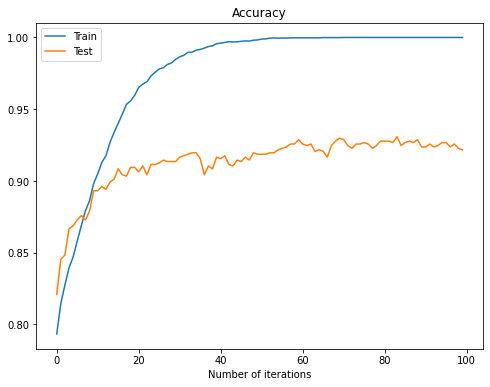

In [16]:
# Plot and display the performance evaluation
xgb_eval = xgb_model_1.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

In [17]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train_reduced, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              #'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

C:\Users\bigal\Anaconda3\envs\learn-env\lib\site-packages\xgboost\data.py:97: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


In [18]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             #'n_estimators':(100,120)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an 
#acquisition function of expected improvement

xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth |
-------------------------------------------------------------
|  1        | -0.4678   |  0.1613   |  0.7385   |  6.566    |
|  2        | -0.4385   |  0.3813   |  0.6462   |  6.222    |
|  3        | -0.3746   |  0.09303  |  0.03838  |  5.334    |
|  4        | -0.5168   |  0.6686   |  0.9429   |  9.323    |
|  5        | -0.473    |  0.8658   |  0.8267   |  8.873    |
|  6        | -0.4017   |  0.6307   |  0.5107   |  9.48     |
|  7        | -0.4657   |  0.3013   |  0.7733   |  5.831    |
|  8        | -0.4173   |  0.7774   |  0.5888   |  8.364    |
|  9        | -0.5      |  1.0      |  0.0      |  10.0     |
|  10       | -0.5      |  0.0      |  0.0      |  9.027    |
|  11       | -0.5      |  1.0      |  0.0      |  3.0      |
|  12       | -0.5      |  1.0      |  0.0      |  7.211    |
|  13       | -0.5      |  0.0      |  0.0      |  3.0      |


In [19]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
#params['n_estimators']= int(params['n_estimators'])

{'gamma': 0.09303299890736783, 'learning_rate': 0.038381185810815066, 'max_depth': 5.334003733964927}


In [20]:
#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
xgb_model_2 = XGBClassifier(**params).fit(X_train_reduced, y_train)

#predicting for training set
train_p2 = xgb_model_2.predict(X_train_reduced)

#Looking at the classification report
print(classification_report(train_p2, y_train))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90      6547
         1.0       0.85      0.89      0.87      4996

    accuracy                           0.89     11543
   macro avg       0.88      0.89      0.88     11543
weighted avg       0.89      0.89      0.89     11543



In [21]:
#predicting for validation set
val_p2 = xgb_model_2.predict(X_val_reduced)

#Looking at the classification report
print(classification_report(val_p2, y_val))

#Attained prediction accuracy on the training set
cm = confusion_matrix(train_p2, y_train)
acc = cm.diagonal().sum()/cm.sum()
print(acc)

              precision    recall  f1-score   support

         0.0       0.64      0.87      0.74       197
         1.0       0.96      0.88      0.92       786

    accuracy                           0.87       983
   macro avg       0.80      0.87      0.83       983
weighted avg       0.90      0.87      0.88       983

0.886078142597245


In [23]:
#predicting for validation set
val_p2 = xgb_model_2.predict(X_val_reduced)

#Looking at the classification report
print(classification_report(val_p2, y_val))

#Attained prediction accuracy on the training set
cm = confusion_matrix(train_p2, y_train)
acc = cm.diagonal().sum()/cm.sum()
print(acc)

#Attained prediction accuracy on the validation set
cm = confusion_matrix(val_p2, y_val)
acc_val = cm.diagonal().sum()/cm.sum()
print(acc_val)

preds = xgb_model_2.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_val, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_val, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_val, best_preds)))

              precision    recall  f1-score   support

         0.0       0.64      0.87      0.74       197
         1.0       0.96      0.88      0.92       786

    accuracy                           0.87       983
   macro avg       0.80      0.87      0.83       983
weighted avg       0.90      0.87      0.88       983

0.886078142597245
0.8748728382502543


NameError: name 'dtest' is not defined

In [24]:
xgb_model_1.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}